In [1]:
!pip install transformers==2.6.0

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data_train = pd.read_csv("/content/gdrive/My Drive/DoDef/task2_train_temp (1).tsv", quotechar = "~",delimiter = "\t", encoding="utf-8-sig").fillna(method="ffill")
data_test = pd.read_csv("/content/gdrive/My Drive/DoDef/task2_test_temp (1).tsv",quotechar = "~", delimiter = "\t", encoding="utf-8-sig").fillna(method="ffill")

In [4]:
data_train.head()

,Sentence #,Word,POS,Tag
0,Sentence: 0,#cymbalta,HT,O
1,Sentence: 0,withdrawal,NN,B-ADR
2,Sentence: 0,has,VBZ,O
3,Sentence: 0,reached,VBN,O
4,Sentence: 0,a,DT,O


In [5]:
data_test.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 0,do,VBP,O
1,Sentence: 0,you,PRP,O
2,Sentence: 0,have,VBP,O
3,Sentence: 0,any,DT,O
4,Sentence: 0,medication,NN,O
5,Sentence: 0,allergies,NNS,B-ADR
6,Sentence: 0,?,.,O
7,Sentence: 0,"""",'',O
8,Sentence: 0,asthma,NN,O
9,Sentence: 0,"!!!""",VB,O


In [0]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        # print (self.grouped)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [0]:
getter_train = SentenceGetter(data_train)
getter_test = SentenceGetter(data_test)

In [0]:
sentences_train = [[word[0] for word in sentence] for sentence in getter_train.sentences]
sentences_test = [[word[0] for word in sentence] for sentence in getter_test.sentences]

In [9]:
labels_train = [[s[2] for s in sentence] for sentence in getter_train.sentences]
labels_test = [[s[2] for s in sentence] for sentence in getter_test.sentences]
print(labels_train[0])
print(labels_test[0])

['O', 'B-ADR', 'O', 'O', 'O', 'O', 'O', 'B-ADR', 'I-ADR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'B-ADR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ADR', 'O', 'O', 'O', 'O', 'O']


In [0]:
tag_values_train = list(set(data_train["Tag"].values))
tag_values_train.append("PAD")
tag2idx_train= {t: i for i, t in enumerate(tag_values_train)}

tag_values_test = list(set(data_test["Tag"].values))
tag_values_test.append("PAD")
tag2idx_test= {t: i for i, t in enumerate(tag_values_test)}

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

Using TensorFlow backend.


'1.5.0+cu101'

In [0]:
MAX_LEN = 75
bs = 32

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [14]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
# !tar -xzf "/content/gdrive/My Drive/DoDef/biobert_large_v1.1_pubmed.tar.gz"   

In [0]:
# !pip install pytorch-pretrained-bert

In [0]:
# import os
# from pytorch_pretrained_bert.convert_tf_checkpoint_to_pytorch import convert_tf_checkpoint_to_pytorch
# path_bin = '/content/biobert_large/pytorch_model.bin'
# path_bert = '/content/biobert_large/'

# if (not os.path.exists(path_bin)):
#   convert_tf_checkpoint_to_pytorch(
#   path_bert + "bio_bert_large_1000k.ckpt",
#   path_bert + "config.json",
#   path_bert + "pytorch_model.bin"
#   )

In [0]:
tokenizer = BertTokenizer.from_pretrained('/content/biobert_large', do_lower_case=False)

In [0]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [0]:
tokenized_texts_and_labels_train = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences_train, labels_train)
]

In [0]:
tokenized_texts_and_labels_test = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences_test, labels_test)
]

In [0]:
tokenized_texts_train = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_train]
labels_train = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_train]

In [0]:
tokenized_texts_test = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_test]
labels_test = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_test]

In [0]:
input_ids_train = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_train],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [0]:
input_ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_test],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [0]:
tags_train = pad_sequences([[tag2idx_train.get(l) for l in lab] for lab in labels_train],
                     maxlen=MAX_LEN, value=tag2idx_train["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_test = pad_sequences([[tag2idx_test.get(l) for l in lab] for lab in labels_test],
                     maxlen=MAX_LEN, value=tag2idx_test["PAD"], padding="post",
                     dtype="long", truncating="post")

In [0]:
attention_masks_train = [[float(i != 0.0) for i in ii] for ii in input_ids_train]

attention_masks_test = [[float(i != 0.0) for i in ii] for ii in input_ids_test]

In [0]:
tr_inputs, val_inputs, tr_tags, val_tags = input_ids_train,input_ids_test,tags_train,tags_test

tr_masks, val_masks, _, _ = attention_masks_train,attention_masks_test,input_ids_train,input_ids_test

In [0]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [0]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [31]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'2.6.0'

In [0]:
model = BertForTokenClassification.from_pretrained(
    "/content/biobert_large",
    num_labels=len(tag2idx_train),
    output_attentions = False,
    output_hidden_states = False
)

In [0]:
model.cuda();

In [0]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [36]:
!pip install seqeval

In [0]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [38]:
loss_values, validation_loss_values = [], []

for _ in trange(6, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values_test[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values_test[l_i] != "PAD"]
    valid_tags = [tag_values_test[l_i] for l in true_labels
                                  for l_i in l if tag_values_test[l_i] != "PAD"]
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Average train loss: 0.46330854515818987


Epoch:  17%|█▋        | 1/6 [01:34<07:53, 94.72s/it]

Validation loss: 0.338846854865551
Validation Accuracy: 0.3701909722222222
Validation F1-Score: 0.3282828282828283

Average train loss: 0.23168985764769948


Epoch:  33%|███▎      | 2/6 [03:09<06:18, 94.69s/it]

Validation loss: 0.28908287174999714
Validation Accuracy: 0.37723958333333335
Validation F1-Score: 0.5018115942028986

Average train loss: 0.1462593834628077


Epoch:  50%|█████     | 3/6 [04:43<04:43, 94.64s/it]

Validation loss: 0.29127069003880024
Validation Accuracy: 0.38069444444444445
Validation F1-Score: 0.5433829973707275

Average train loss: 0.12187115891891367


Epoch:  67%|██████▋   | 4/6 [06:18<03:09, 94.60s/it]

Validation loss: 0.29127069003880024
Validation Accuracy: 0.38069444444444445
Validation F1-Score: 0.5433829973707275

Average train loss: 0.1231801008038661


Epoch:  83%|████████▎ | 5/6 [07:52<01:34, 94.59s/it]

Validation loss: 0.29127069003880024
Validation Accuracy: 0.38069444444444445
Validation F1-Score: 0.5433829973707275

Average train loss: 0.1244004962637144


Epoch: 100%|██████████| 6/6 [09:27<00:00, 94.58s/it]

Validation loss: 0.29127069003880024
Validation Accuracy: 0.38069444444444445
Validation F1-Score: 0.5433829973707275



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


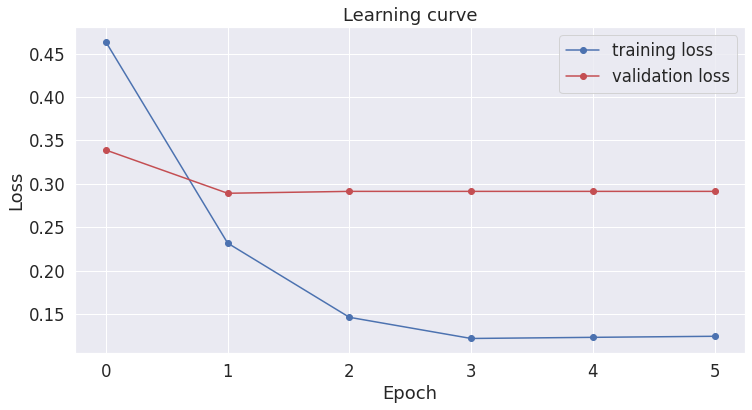

In [39]:

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [40]:
from sklearn.metrics import classification_report
print(classification_report(valid_tags, pred_tags, target_names=["B-ADR","I-ADR","O"]))

              precision    recall  f1-score   support

       B-ADR       0.65      0.69      0.67       514
       I-ADR       0.58      0.50      0.53       427
           O       0.96      0.96      0.96      6483

    accuracy                           0.91      7424
   macro avg       0.73      0.72      0.72      7424
weighted avg       0.91      0.91      0.91      7424



In [41]:
for i in range(len(pred_tags)):
  if pred_tags[i] == "B-ADR" or pred_tags[i] == "I-ADR":
    pred_tags[i] = "ADR"

for i in range(len(valid_tags)):
  if valid_tags[i] == "B-ADR" or valid_tags[i] == "I-ADR":
    valid_tags[i] = "ADR"
  
print(classification_report(valid_tags, pred_tags, target_names=["ADR","O"]))

              precision    recall  f1-score   support

         ADR       0.71      0.69      0.70       941
           O       0.96      0.96      0.96      6483

    accuracy                           0.93      7424
   macro avg       0.83      0.83      0.83      7424
weighted avg       0.92      0.93      0.93      7424



In [42]:
test_sentence = """
#paracetamol y u make me so sleepy 
"""
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values_test[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	#
O	paracetamol
O	y
O	u
O	make
O	me
O	so
B-ADR	sleepy
O	[SEP]


In [49]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [0]:
!cp -r ./model_save/ "/content/gdrive/My Drive/DoDef/bert_new"